# End to end examples

## Boston with Flux

In [1]:
using Pkg ; Pkg.activate("D:/JULIA/6_ML_with_Julia/EX-boston-flux"); Pkg.instantiate()

  Activating project at `D:\JULIA\6_ML_with_Julia\EX-boston-flux`


> Getting started <br>
> Tuning

### Getting started

---


In [2]:
import MLJFlux
import MLJ
import DataFrames: DataFrame
import Statistics
import Flux
using Random
using PyPlot

Random.seed!(11)

TaskLocalRNG()

Loading the Boston dataset. Our aim will be to implement a neural nerwork regressor to predict the price of a house, given a number of features.

In [3]:
features, targets = MLJ.@load_boston
features = DataFrame(features)
@show size(features)
@show targets[1:3]
first(features, 3) |> MLJ.pretty

size(features) = (506, 12)
targets[1:3] = [24.0, 21.6, 34.7]
┌────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┐
│ Crim       │ Zn         │ Indus      │ NOx        │ Rm         │ Age        │ Dis        │ Rad        │ Tax        │ PTRatio    │ Black      │ LStat      │
│ Float64    │ Float64    │ Float64    │ Float64    │ Float64    │ Float64    │ Float64    │ Float64    │ Float64    │ Float64    │ Float64    │ Float64    │
│ Continuous │ Continuous │ Continuous │ Continuous │ Continuous │ Continuous │ Continuous │ Continuous │ Continuous │ Continuous │ Continuous │ Continuous │
├────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┤
│ 0.00632    │ 18.0       │ 2.31       │ 0.538      │ 6.575      │ 65.2       │ 4.09       │ 1.0        │ 296.0      │ 15.3       │ 396.9      │ 4.98

Next obvious steps: partitioning into train and test set

In [4]:
train, test = MLJ.partition(collect(eachindex(targets)), 0.70, rng = 52)

([358, 422, 334, 476, 1, 441, 12, 115, 240, 104  …  250, 497, 345, 132, 291, 277, 257, 379, 218, 166], [225, 189, 245, 418, 295, 135, 463, 487, 37, 207  …  355, 483, 30, 433, 84, 242, 368, 147, 48, 253])

Let us try to implement an Neural Network regressor using Flux.jl. MLJFlux.jl provides an MLJ interface to the Flux.jl deep learning framework. The package provides four essential models: `NeuralNetworkRegressor`, `MultitargetNeuralNetworkRegressor`, `NeuralNetworkClassifier` and `ImageClassifier`.

At the heart of these models is a neural network. This is specified using the `builder` parameter. Creating a builder object consists of two steps: 

* Step 1: Creating a new struct inherited from MLJFlux.Builder. 
    - MLJFlux.Builder is an abstract structure used for the purpose of dispatching. 
    - Suppose we define a new struct called MyNetworkBuilder. 
    - This can contain any attribute required to build the model later. (Step 2)

<br>
Let's use Dense Neural Network with 2 hidden layers.

In [5]:
mutable struct MyNetworkBuilder <: MLJFlux.Builder
    n1::Int # Number of cells in the first hidden layer
    n2::Int # Number of cells in the second hidden layer
end

Step 2: Building the neural network from this object. Extend the `MLJFlux.build` function. This takes in 4 arguments: The `MyNetworkBuilder` instance, a random number generator or seed `rng`, the input dimension (`n_in`) and output dimension (`n_out`).

In [6]:
function MLJFlux.build(model::MyNetworkBuilder, rng, n_in, n_out)
    init = Flux.glorot_uniform(rng)
    layer1 = Flux.Dense(n_in, model.n1, init = init)
    layer2 = Flux.Dense(model.n1, model.n2, init = init)
    layer3 = Flux.Dense(model.n2, n_out, init = init)
    return Flux.Chain(layer1, layer2, layer3)
end

Alternatively, there a macro shortcut to take care of both steps at once. For details, do `?MLJFlux.@builder`.

All definitions ready, let us create an object of this:

In [7]:
?MLJFlux.@builder

```
@builder neural_net
```

Creates a builder for `neural_net`. The variables `rng`, `n_in`, `n_out` and `n_channels` can be used to create builders for any random number generator `rng`, input and output sizes `n_in` and `n_out` and number of input channels `n_channels`.

# Examples

```jldoctest
julia> import MLJFlux: @builder;

julia> nn = NeuralNetworkRegressor(builder = @builder(Chain(Dense(n_in, 64, relu),
                                                            Dense(64, 32, relu),
                                                            Dense(32, n_out))));

julia> conv_builder = @builder begin
           front = Chain(Conv((3, 3), n_channels => 16), Flux.flatten)
           d = Flux.outputsize(front, (n_in..., n_channels, 1)) |> first
           Chain(front, Dense(d, n_out));
       end

julia> conv_nn = NeuralNetworkRegressor(builder = conv_builder);
```


In [8]:
myregressor = MyNetworkBuilder(20, 10)

MyNetworkBuilder


Since the boston dataset is a regression problem, we'll be using `NeuralNetworkRegressor` here. One thing to remember is that a `NeuralNetworkRegressor` object works seamlessly like any other MLJ model: you can wrap it in an MLJ `machine` and do anything you'd do otherwise.

Let's start by defining our `NeuralNetworkRegressor` object, that takes `myregressor` as it's parameter.

In [9]:
nnregressor = MLJFlux.NeuralNetworkRegressor(builder = myregressor, epochs = 10)

NeuralNetworkRegressor(
    builder = MyNetworkBuilder(
            n1 = 20,
            n2 = 10),
    optimiser = Flux.Optimise.ADAM(0.001, (0.9, 0.999), IdDict{Any, Any}()),
    loss = Flux.Losses.mse,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    rng = Random._GLOBAL_RNG(),
    optimiser_changes_trigger_retraining = false,
    acceleration = ComputationalResources.CPU1{Nothing}(nothing))

Other parameters that NeuralNetworkRegressor takes can be found hear:
> https://github.com/alan-turing-institute/MLJFlux.jl#model-hyperparameters

`nnregressor` now acts like any other MLJ model. Let's try wrapping it in a MLJ machine and calling `fit!, predict`.

In [10]:
mach = MLJ.machine(nnregressor, features, targets)

Machine{NeuralNetworkRegressor{MyNetworkBuilder,…},…} trained 0 times; caches data
  model: MLJFlux.NeuralNetworkRegressor{MyNetworkBuilder, Flux.Optimise.ADAM, typeof(Flux.Losses.mse)}
  args: 
    1:	Source @745 ⏎ `ScientificTypesBase.Table{AbstractVector{ScientificTypesBase.Continuous}}`
    2:	Source @820 ⏎ `AbstractVector{ScientificTypesBase.Continuous}`


Let's fit this on the train set

In [11]:
MLJ.fit!(mach, rows = train, verbosity = 3)

┌ Info: Training Machine{NeuralNetworkRegressor{MyNetworkBuilder,…},…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: Loss is 3410.0
└ @ MLJFlux C:\Users\jeffr\.julia\packages\MLJFlux\ex3rh\src\core.jl:127
┌ Info: Loss is 108.2
└ @ MLJFlux C:\Users\jeffr\.julia\packages\MLJFlux\ex3rh\src\core.jl:127
┌ Info: Loss is 105.1
└ @ MLJFlux C:\Users\jeffr\.julia\packages\MLJFlux\ex3rh\src\core.jl:127
┌ Info: Loss is 101.1
└ @ MLJFlux C:\Users\jeffr\.julia\packages\MLJFlux\ex3rh\src\core.jl:127
┌ Info: Loss is 97.35
└ @ MLJFlux C:\Users\jeffr\.julia\packages\MLJFlux\ex3rh\src\core.jl:127
┌ Info: Loss is 96.48
└ @ MLJFlux C:\Users\jeffr\.julia\packages\MLJFlux\ex3rh\src\core.jl:127
┌ Info: Loss is 98.54
└ @ MLJFlux C:\Users\jeffr\.julia\packages\MLJFlux\ex3rh\src\core.jl:127
┌ Info: Loss is 101.2
└ @ MLJFlux C:\Users\jeffr\.julia\packages\MLJFlux\ex3rh\src\core.jl:127
┌ Info: Loss is 102.3
└ @ MLJFlux C:\Users\jeffr\.julia\packages\MLJFlux\ex3rh\src\core.jl

Machine{NeuralNetworkRegressor{MyNetworkBuilder,…},…} trained 1 time; caches data
  model: MLJFlux.NeuralNetworkRegressor{MyNetworkBuilder, Flux.Optimise.ADAM, typeof(Flux.Losses.mse)}
  args: 
    1:	Source @745 ⏎ `ScientificTypesBase.Table{AbstractVector{ScientificTypesBase.Continuous}}`
    2:	Source @820 ⏎ `AbstractVector{ScientificTypesBase.Continuous}`


As we can see, the training loss decreases at each epoch, showing the the neural network is gradually learning form the training set.

In [12]:
preds = MLJ.predict(mach, features[test, :])

print(preds[1:5])

[31.564108537181767, 29.851880088092244, 24.77323694590281, -9.328833979969517, 22.551995322046096]

Now let's retrain our model. One thing to remember is that retrainig may OR may not re-initialize our neural network model parameters. For example, changing the number of epochs to 15 will not causes the model to train to 15 epcohs, but just 5 additional epochs.

In [13]:
nnregressor.batch_size = 2
MLJ.fit!(mach, rows = train, verbosity = 3)

┌ Info: Updating Machine{NeuralNetworkRegressor{MyNetworkBuilder,…},…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:465
┌ Info: Loss is 3409.0
└ @ MLJFlux C:\Users\jeffr\.julia\packages\MLJFlux\ex3rh\src\core.jl:127
┌ Info: Loss is 123.3
└ @ MLJFlux C:\Users\jeffr\.julia\packages\MLJFlux\ex3rh\src\core.jl:127
┌ Info: Loss is 100.5
└ @ MLJFlux C:\Users\jeffr\.julia\packages\MLJFlux\ex3rh\src\core.jl:127
┌ Info: Loss is 87.94
└ @ MLJFlux C:\Users\jeffr\.julia\packages\MLJFlux\ex3rh\src\core.jl:127
┌ Info: Loss is 79.86
└ @ MLJFlux C:\Users\jeffr\.julia\packages\MLJFlux\ex3rh\src\core.jl:127
┌ Info: Loss is 74.46
└ @ MLJFlux C:\Users\jeffr\.julia\packages\MLJFlux\ex3rh\src\core.jl:127
┌ Info: Loss is 70.78
└ @ MLJFlux C:\Users\jeffr\.julia\packages\MLJFlux\ex3rh\src\core.jl:127
┌ Info: Loss is 68.21
└ @ MLJFlux C:\Users\jeffr\.julia\packages\MLJFlux\ex3rh\src\core.jl:127
┌ Info: Loss is 66.37
└ @ MLJFlux C:\Users\jeffr\.julia\packages\MLJFlux\ex3rh\src\core.jl

Machine{NeuralNetworkRegressor{MyNetworkBuilder,…},…} trained 2 times; caches data
  model: MLJFlux.NeuralNetworkRegressor{MyNetworkBuilder, Flux.Optimise.ADAM, typeof(Flux.Losses.mse)}
  args: 
    1:	Source @745 ⏎ `ScientificTypesBase.Table{AbstractVector{ScientificTypesBase.Continuous}}`
    2:	Source @820 ⏎ `AbstractVector{ScientificTypesBase.Continuous}`


Another bit to remember here is that changing the optimiser doesn't cause retaining by default. However, the `optimiser_changes_trigger_retraining` in NeuralNetworkRegressor can be toggled to accomodate this. This allows one to modify the learning rate, for example, after an initial burn-in period.

In [14]:
# Inspecting out-of-sample loss as a function of epochs

r = MLJ.range(nnregressor, :epochs, lower = 1, upper = 30, scale =:log10)
curve = MLJ.learning_curve(nnregressor, features, targets, 
                            range = r,
                            resampling=MLJ.Holdout(fraction_train = 0.7),
                            measure = MLJ.l2)

┌ Info: Training Machine{DeterministicTunedModel{Grid,…},…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: Attempting to evaluate 19 models.
└ @ MLJTuning C:\Users\jeffr\.julia\packages\MLJTuning\Al9yX\src\tuned_models.jl:680
Evaluating over 19 metamodels: 100%[=========================] Time: 0:00:03


(parameter_name = "epochs",
 parameter_scale = :log10,
 parameter_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 19, 21, 24, 27, 30],
 measurements = [270.6511542056684, 116.18713410853353, 106.29054457322856, 115.94225343213621, 145.03030588545656, 182.82636709439396, 217.87801123700416, 244.66210980183166, 262.3465606275757, 272.11458362110164, 273.67751892416896, 267.5505908456089, 245.07214221165663, 214.18558687381702, 182.2747175497356, 155.18616164931225, 127.74599692776592, 113.56806306909242, 107.87888512583167],)

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\jeffr\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


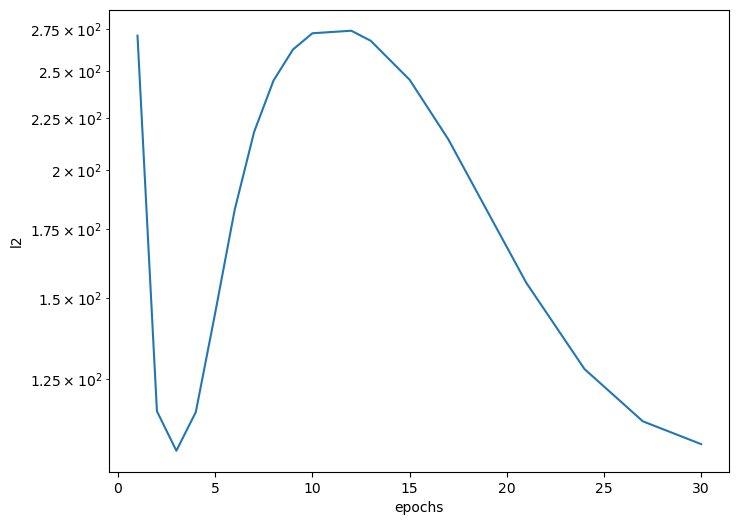

In [15]:
figure(figsize = (8, 6))
plt.plot(curve.parameter_values, curve.measurements)
yscale("log")
xlabel(curve.parameter_name)
ylabel("l2")

savefig("./plots/4.11.1.png")

### Tuning

---

As mentioned above, `nnregressor` can act like any other MLJ model. Let's try to tune the batch_size parameter.

In [16]:
bs = MLJ.range(nnregressor, :batch_size, lower = 1, upper = 5)

tm = MLJ.TunedModel(model = nnregressor, ranges = [bs, ], measure = MLJ.l2)

DeterministicTunedModel(
    model = NeuralNetworkRegressor(
            builder = MyNetworkBuilder,
            optimiser = Flux.Optimise.ADAM(0.001, (0.9, 0.999), IdDict{Any, Any}()),
            loss = Flux.Losses.mse,
            epochs = 10,
            batch_size = 2,
            lambda = 0.0,
            alpha = 0.0,
            rng = Random._GLOBAL_RNG(),
            optimiser_changes_trigger_retraining = false,
            acceleration = ComputationalResources.CPU1{Nothing}(nothing)),
    tuning = Grid(
            goal = nothing,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.7,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = LPLoss(p = 2),
    weights = nothing,
    operation = nothing,
    range = MLJBase.NumericRange{Int64, MLJBase.Bounded, Symbol}[NumericRange(1 ≤ batch_size ≤ 5; origin=3.0, unit=2.0)],
    selection_heuristic = M

For more on tuning, refer to the model-tuning tutorial.

In [17]:
m = MLJ.machine(tm, features, targets)

Machine{DeterministicTunedModel{Grid,…},…} trained 0 times; caches data
  model: MLJTuning.DeterministicTunedModel{MLJTuning.Grid, MLJFlux.NeuralNetworkRegressor{MyNetworkBuilder, Flux.Optimise.ADAM, typeof(Flux.Losses.mse)}}
  args: 
    1:	Source @049 ⏎ `ScientificTypesBase.Table{AbstractVector{ScientificTypesBase.Continuous}}`
    2:	Source @590 ⏎ `AbstractVector{ScientificTypesBase.Continuous}`


In [18]:
MLJ.fit!(m)

┌ Info: Training Machine{DeterministicTunedModel{Grid,…},…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: Attempting to evaluate 5 models.
└ @ MLJTuning C:\Users\jeffr\.julia\packages\MLJTuning\Al9yX\src\tuned_models.jl:680
Evaluating over 5 metamodels: 100%[=========================] Time: 0:00:01


Machine{DeterministicTunedModel{Grid,…},…} trained 1 time; caches data
  model: MLJTuning.DeterministicTunedModel{MLJTuning.Grid, MLJFlux.NeuralNetworkRegressor{MyNetworkBuilder, Flux.Optimise.ADAM, typeof(Flux.Losses.mse)}}
  args: 
    1:	Source @049 ⏎ `ScientificTypesBase.Table{AbstractVector{ScientificTypesBase.Continuous}}`
    2:	Source @590 ⏎ `AbstractVector{ScientificTypesBase.Continuous}`


This evaluated the model at each value of our range. The best value is:

In [19]:
MLJ.fitted_params(m).best_model.batch_size

5